# Импортирование библиотек и базовые настройки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Вспомогательные функции

In [2]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None
    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None
    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

# Загрузка датасетов

In [3]:
datasets = {}
X = {}
for dataset_num in range(1,4):
    datasets[f"df_{dataset_num}"] = pd.read_csv(f"data/S07-hw-dataset-0{dataset_num}.csv")
datasets

{'df_1':        sample_id        f01        f02       f03         f04        f05  \
 0              0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
 1              1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
 2              2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
 3              3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
 4              4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   
 ...          ...        ...        ...       ...         ...        ...   
 11995      11995  15.358432  56.974156 -1.089617  -95.891749   8.909345   
 11996      11996  -5.781842  71.198182 -0.201762  -54.336472   4.903560   
 11997      11997  -7.573306  70.017900 -0.159869   17.167497  -3.809988   
 11998      11998  13.856888  88.341387 -1.429989 -101.905925  10.759963   
 11999      11999 -15.263727 -32.512531  0.215198   19.825822   1.272256   
 
              f06         f07       f08  
 0     -12.291287   -6.836847 -0.504

In [4]:
for df_name, df in datasets.items():
    print(f"----- DATASET: '{df_name}' -----\n")
    print(df.head(), "\n")
    df.info()
    print("\n",df.describe(),"\n")
    # Пропуски
    for column in df.columns:
        if df[column].isna().mean()*100 != 0:
            print(f"Доля пропусков в колонке {column}: {df[column].isna().mean()*100:.2f}% ")
            print(df[df[column].isna()])
        else: 
            print(f"В колонке {column} нет пропусков")
    print("Строковые колонки:", df.select_dtypes(include=['object']).columns.to_list())
    print("Категориальные колонки:", df.select_dtypes(include=['category']).columns.to_list()) # Все признаки числовые
    X[f"{df_name}"] = df.drop("sample_id",axis=1)

----- DATASET: 'df_1' -----

   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12

In [5]:
# X для каждого датасета
for _, item in X.items():
    print(item.columns.to_list())

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']
['x1', 'x2', 'z_noise']
['x1', 'x2', 'f_corr', 'f_noise']


# Препроцессинг

In [6]:
scaler = StandardScaler()
X_scaled = {}
for df_name, x in X.items():
    X_scaled[f"{df_name}"] = scaler.fit_transform(x)
# Пропусков и категориальных признаков нет
X_scaled

{'df_1': array([[ 0.17142668, -1.46280499,  0.43827875, ..., -0.89591542,
         -0.11539556, -0.84301268],
        [ 1.60302144,  0.55306178, -2.1005838 , ...,  2.2545476 ,
         -0.83142723,  0.6304788 ],
        [ 1.90373017,  0.95758263, -2.19656934, ...,  1.68513022,
          0.74843886,  0.52428406],
        ...,
        [-0.46746486,  0.83750509,  0.12423596, ..., -0.42714879,
         -1.65916612,  1.36483461],
        [ 1.47828378,  1.1389387 , -2.41291263, ...,  1.91602935,
         -0.33375476,  0.48180103],
        [-1.16571448, -0.849189  ,  0.87345715, ...,  0.09937317,
         -1.7957767 , -0.92784466]], shape=(12000, 8)),
 'df_2': array([[-0.39789177, -3.14730563,  2.61542782],
        [-1.57409478,  2.39537899,  0.7363646 ],
        [-1.64703263, -0.60266152, -2.35251356],
        ...,
        [ 0.20229915,  0.65430629, -0.32099036],
        [ 1.45797826,  0.07467672, -0.11895964],
        [ 1.52913739, -0.59689713, -0.70895773]], shape=(8000, 3)),
 'df_3': arra

# Модели недели 7

## KMeans

In [7]:
kmeans_ks = list(range(2, 21))

In [8]:
def eval_kmeans_grid(X_scaled, ks):
    results = []
    for k in ks:
        model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = model.fit_predict(X_scaled)
        metrics = safe_cluster_metrics(X_scaled, labels)
        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

In [9]:
kmeans_results = {}
kmeans_results_unscaled = {} # для наглядности
for df_name, x in X_scaled.items():
    kmeans_results[df_name] = eval_kmeans_grid(x, kmeans_ks)
    print(f"{df_name}:",len(kmeans_results[df_name]), kmeans_results[df_name][0]["params"], kmeans_results[df_name][-1]["params"])
for df_name, x in X.items():
    kmeans_results_unscaled[df_name] = eval_kmeans_grid(x, kmeans_ks)
    print(f"{df_name}:",len(kmeans_results[df_name]), kmeans_results[df_name][0]["params"], kmeans_results[df_name][-1]["params"])

df_1: 19 {'k': 2} {'k': 20}
df_2: 19 {'k': 2} {'k': 20}
df_3: 19 {'k': 2} {'k': 20}
df_1: 19 {'k': 2} {'k': 20}
df_2: 19 {'k': 2} {'k': 20}
df_3: 19 {'k': 2} {'k': 20}



Scaled

[0.5216395622404242, 0.39675785208949865, 0.38330054183984436, 0.3548010094581461, 0.3585612534599804, 0.3246065284402385, 0.26887342610287457, 0.2533723319267118, 0.26291441714215824, 0.2658890699274932, 0.2685629760948074, 0.27442565141483244, 0.2787258404482488, 0.28835066131026454, 0.28537028050526086, 0.2801490190966997, 0.27453968319919525, 0.2720445860130438, 0.2677946103186128] 
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


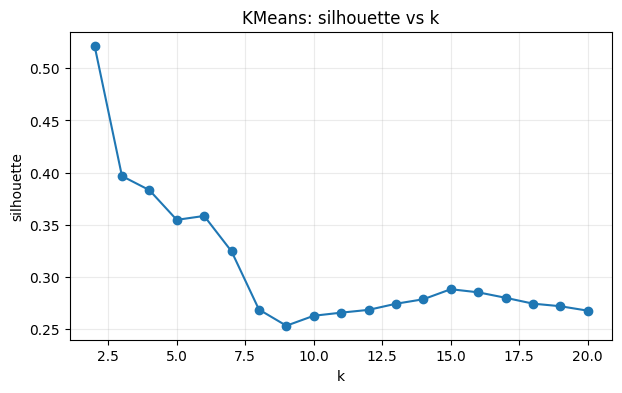

[0.3068610017701601, 0.27004522856451274, 0.2514805632951281, 0.25211519070471305, 0.25981972898842143, 0.2536432556085209, 0.25230459123826915, 0.2524627947838528, 0.2608689477630066, 0.2659443673992366, 0.26363892881483025, 0.26541233783193924, 0.27186380006741345, 0.27601627890666625, 0.2838542344783782, 0.28271302736758425, 0.27931135924632655, 0.27892044023933305, 0.28138732499450486] 
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


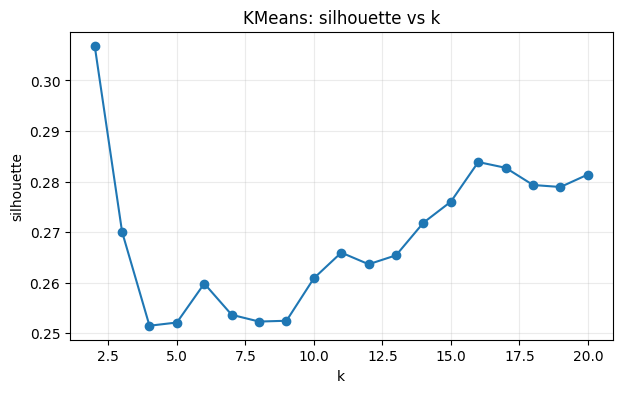

[0.2989049482650359, 0.31554470037825183, 0.3146186578997614, 0.299296734735238, 0.29314949913879973, 0.2798534492101504, 0.28949142967979535, 0.28479131908460764, 0.2788945201029795, 0.27631908370811337, 0.27597762131738773, 0.2708346152326347, 0.2727141627581645, 0.2704264370246084, 0.2677974739934453, 0.263559678167275, 0.2563220267262474, 0.2518580043054598, 0.2505865350430932] 
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


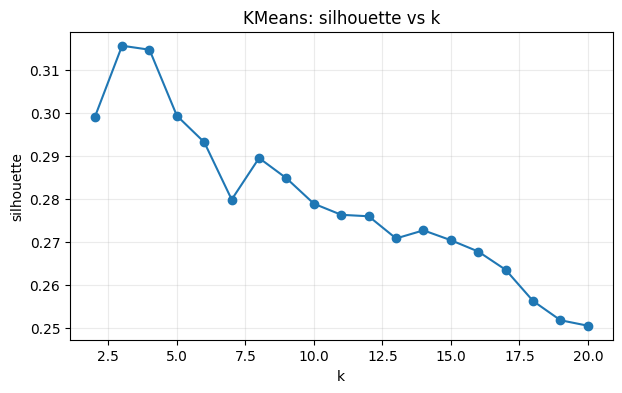


Unscaled (для наглядности)

[0.44674907306090744, 0.40268066366451105, 0.3904988203951211, 0.37134817367895057, 0.37023633300835795, 0.3490116891604154, 0.3651267832156986, 0.3774802701901989, 0.4059370625383863, 0.3969326156880463, 0.4071143424135579, 0.414510734636865, 0.42310475865733116, 0.41566343416700785, 0.42295428794188344, 0.4206078059006157, 0.41512820396102096, 0.4152683927779007, 0.41251450813788976] 
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


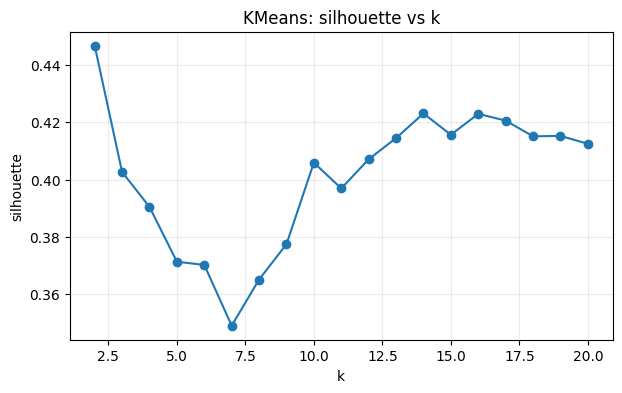

[0.5231887723926523, 0.48816879111310457, 0.4547096293167109, 0.4393809041660667, 0.42723818353446974, 0.40688028787938246, 0.38811294566132015, 0.37541676393467593, 0.36252441534853164, 0.34669254808198996, 0.32757048084662926, 0.3131105343900741, 0.30316167897524743, 0.3020000893604864, 0.29631198144090787, 0.2987636462843012, 0.2943258147189811, 0.298432825760191, 0.2975282696870812] 
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


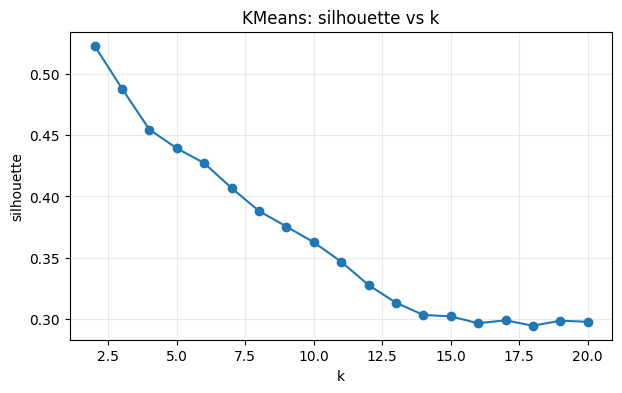

[0.33627020083588555, 0.388486250130702, 0.4418431635218333, 0.45606572856193633, 0.40703657203754623, 0.3713138904996149, 0.33736186585908834, 0.3298110370724894, 0.3053617106601893, 0.30811630788569455, 0.29639286868342557, 0.2922099496682461, 0.29300304236164393, 0.2763392320365004, 0.2774000053579647, 0.27589861699486556, 0.2778568924068958, 0.26563970418348604, 0.2672952545713383] 
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


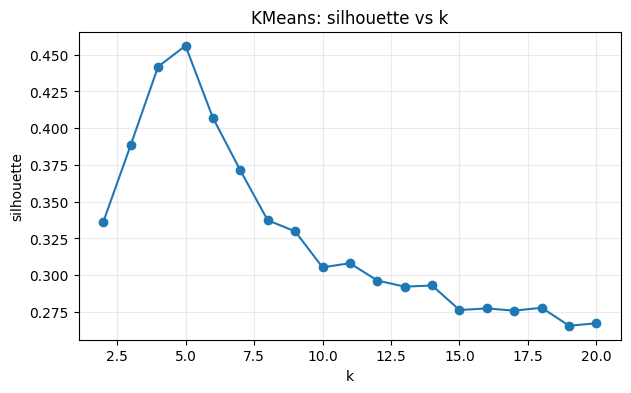

In [10]:
# Silhouette по k
print("\nScaled\n")
for df_name, df in kmeans_results.items():
    ks = [r["params"]["k"] for r in kmeans_results[df_name]]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results[df_name]]
    print(sil, "\n", ks)
    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title("KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.show()
print("\nUnscaled (для наглядности)\n")
for df_name, df in kmeans_results_unscaled.items():
    ks = [r["params"]["k"] for r in kmeans_results_unscaled[df_name]]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results_unscaled[df_name]]
    print(sil, "\n", ks)
    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title("KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.show()